[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Train Player Detector

---

[![Download Dataset](https://app.roboflow.com/images/download-dataset-badge.svg)](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc)

This notebook is based on the [How to Train YOLOv8 Object Detection on a Custom Dataset](https://github.com/roboflow/notebooks/blob/main/notebooks/train-yolov8-object-detection-on-custom-dataset.ipynb) notebook from the [roboflow/notebooks](https://github.com/roboflow/notebooks) repository.

## Configure API keys

- Open your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [10]:
!nvidia-smi

Sun Feb 16 17:25:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install dependencies

In [12]:
!pip install -q ultralytics roboflow

## Imports

In [13]:
from roboflow import Roboflow
from google.colab import userdata
from IPython.display import Image

## Pull dataset

In [14]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')


rf = Roboflow(api_key="ng6VHJaRaCXcTt4lInM2")
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(12)
dataset = version.download("yolov8")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to football-players-detection-12 in yolov8:: 100%|██████████| 756/756 [00:00<00:00, 2625.27it/s]


**NOTE:** Update `data.yaml` structure to align with the latest requirements of the `ultralytics` package.



In [16]:
!sed -i 's|\(train: \).*|\1../train/images|' {dataset.location}/data.yaml
!sed -i 's|\(val: \).*|\1../valid/images|' {dataset.location}/data.yaml

## Custom training

In [20]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8x.pt data={dataset.location}/data.yaml batch=2 epochs=10 imgsz=640 plots=True

/content
Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/datasets/football-players-detection-12/data.yaml, epochs=10, time=None, patience=100, batch=2, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show

In [21]:
!ls {HOME}/runs/detect/train/

args.yaml					    labels_correlogram.jpg  weights
events.out.tfevents.1739726843.23ed95b5bda1.6632.0  labels.jpg


/content


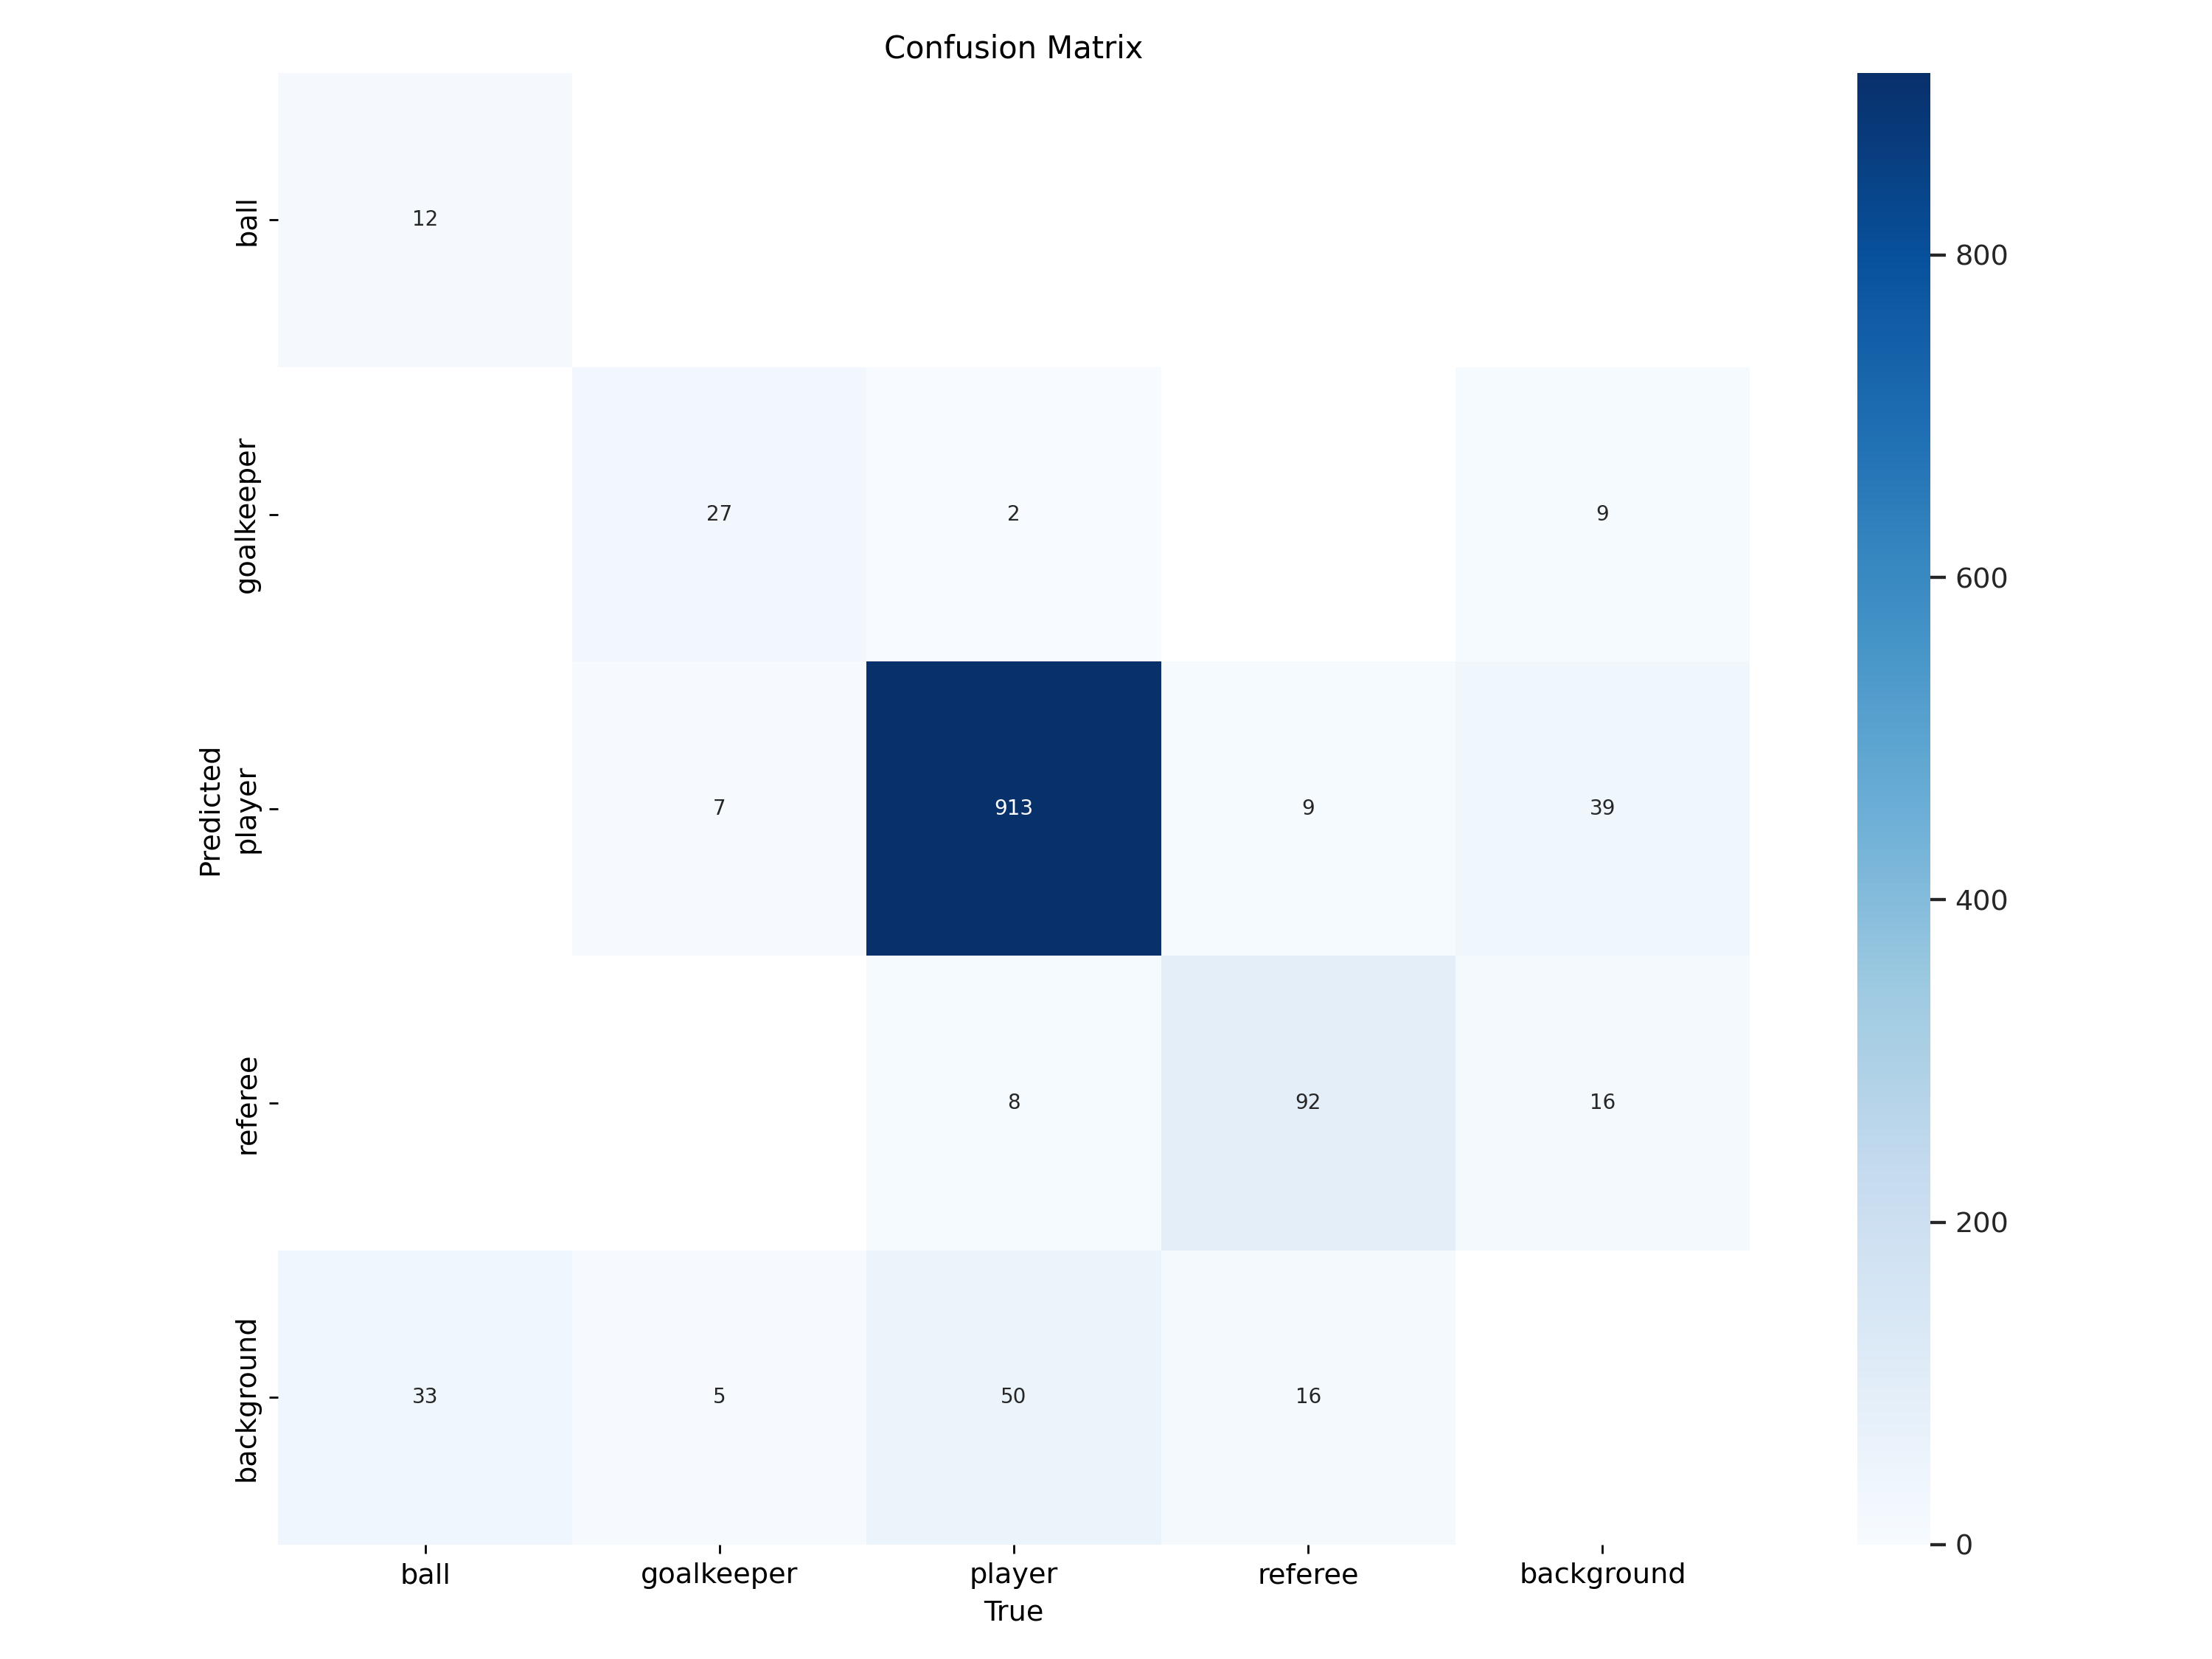

In [33]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train4/confusion_matrix.png', width=600)

/content


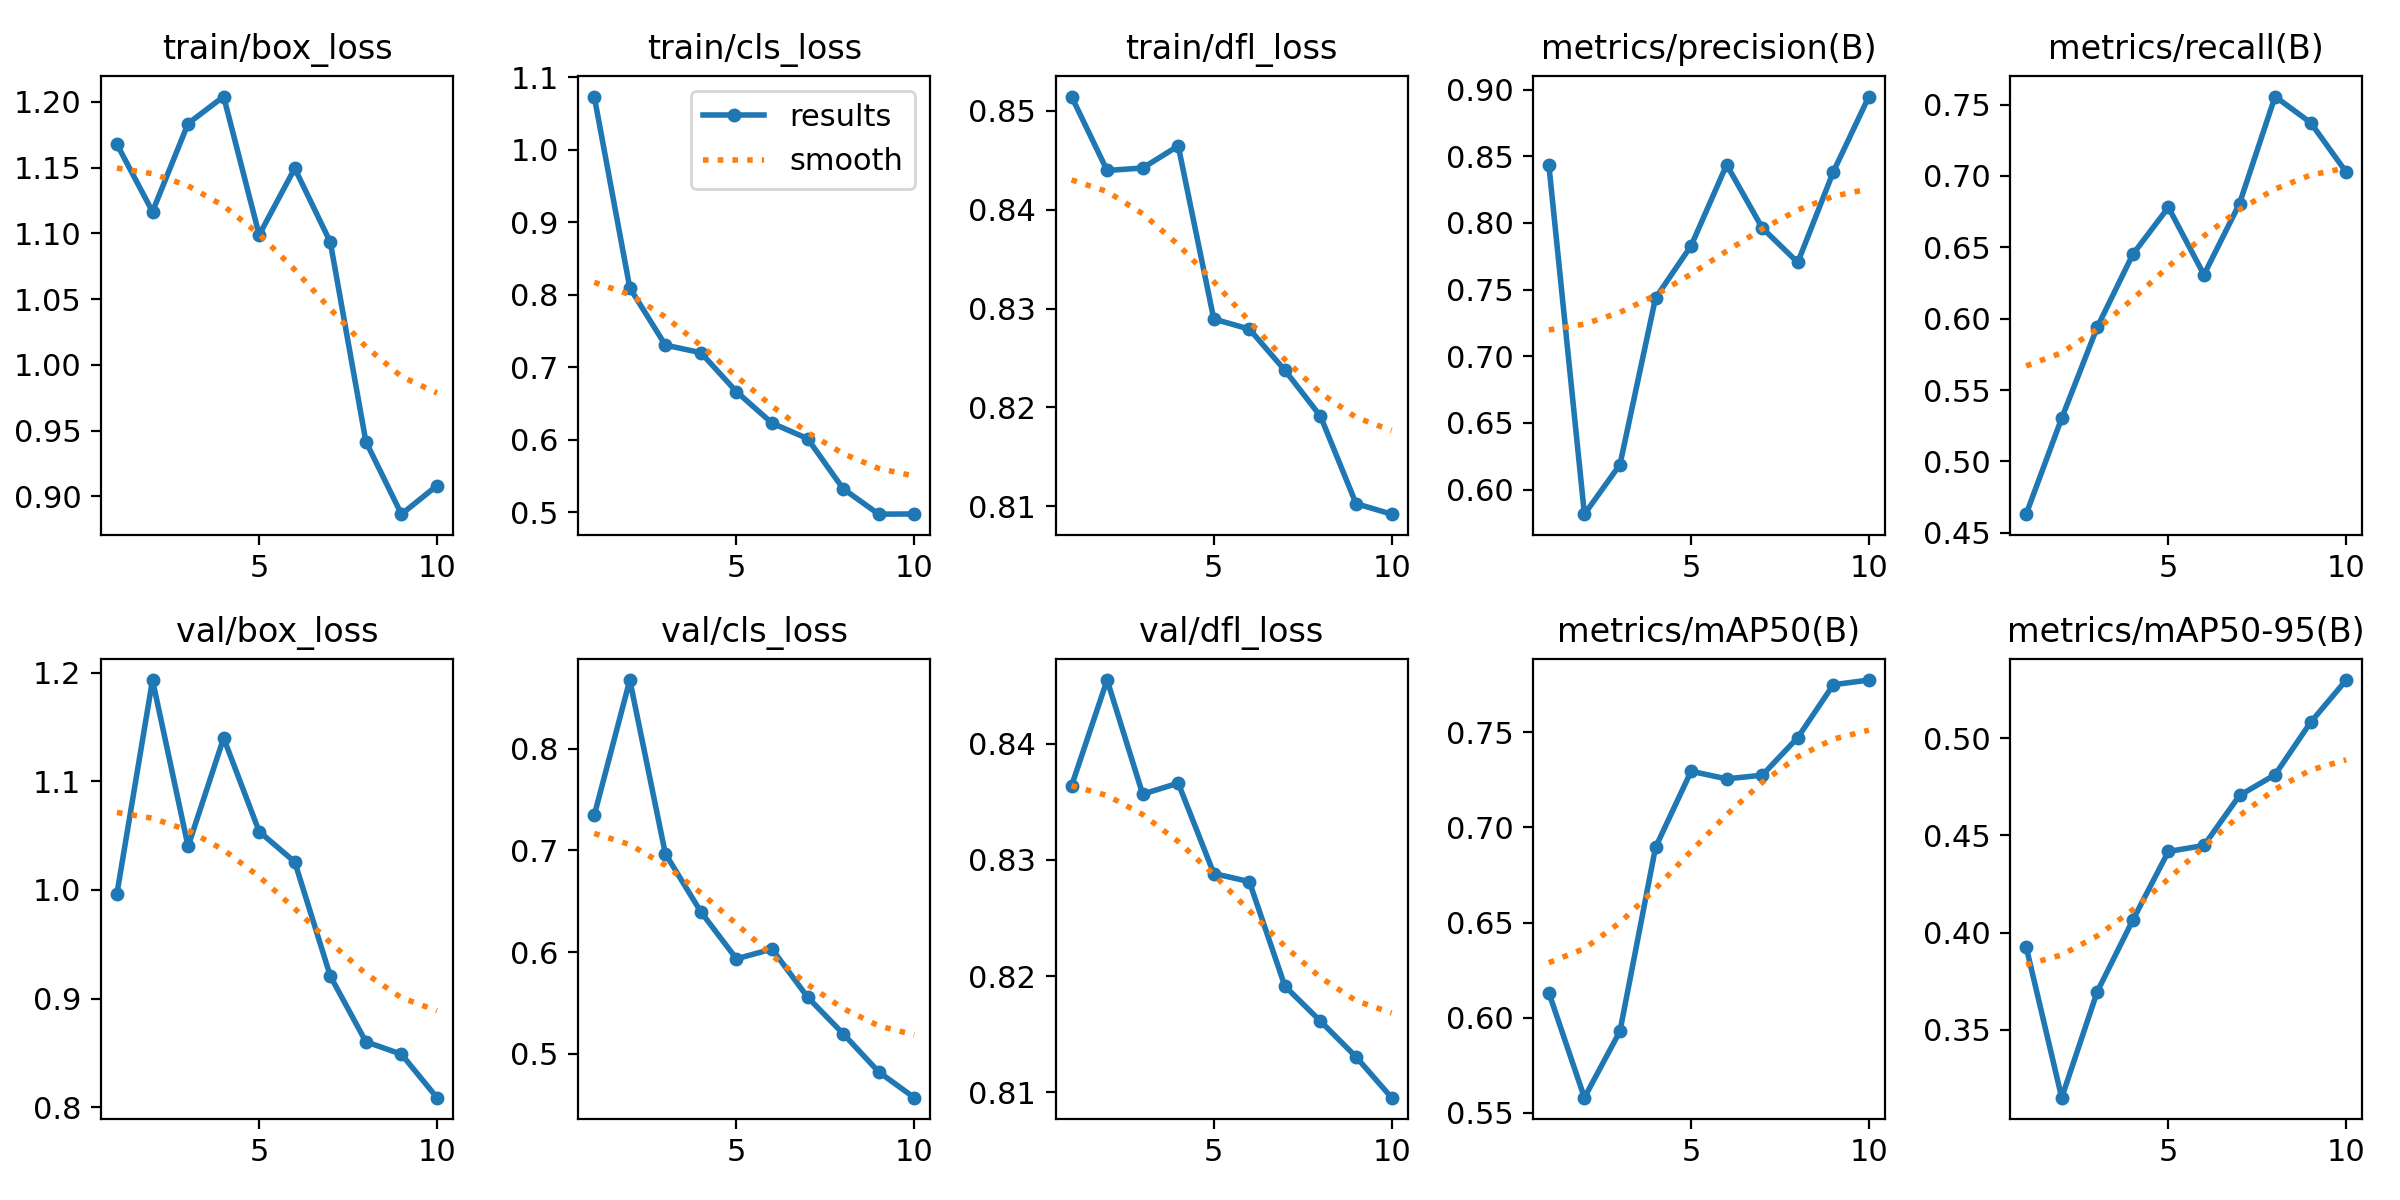

In [34]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train4/results.png', width=600)

/content


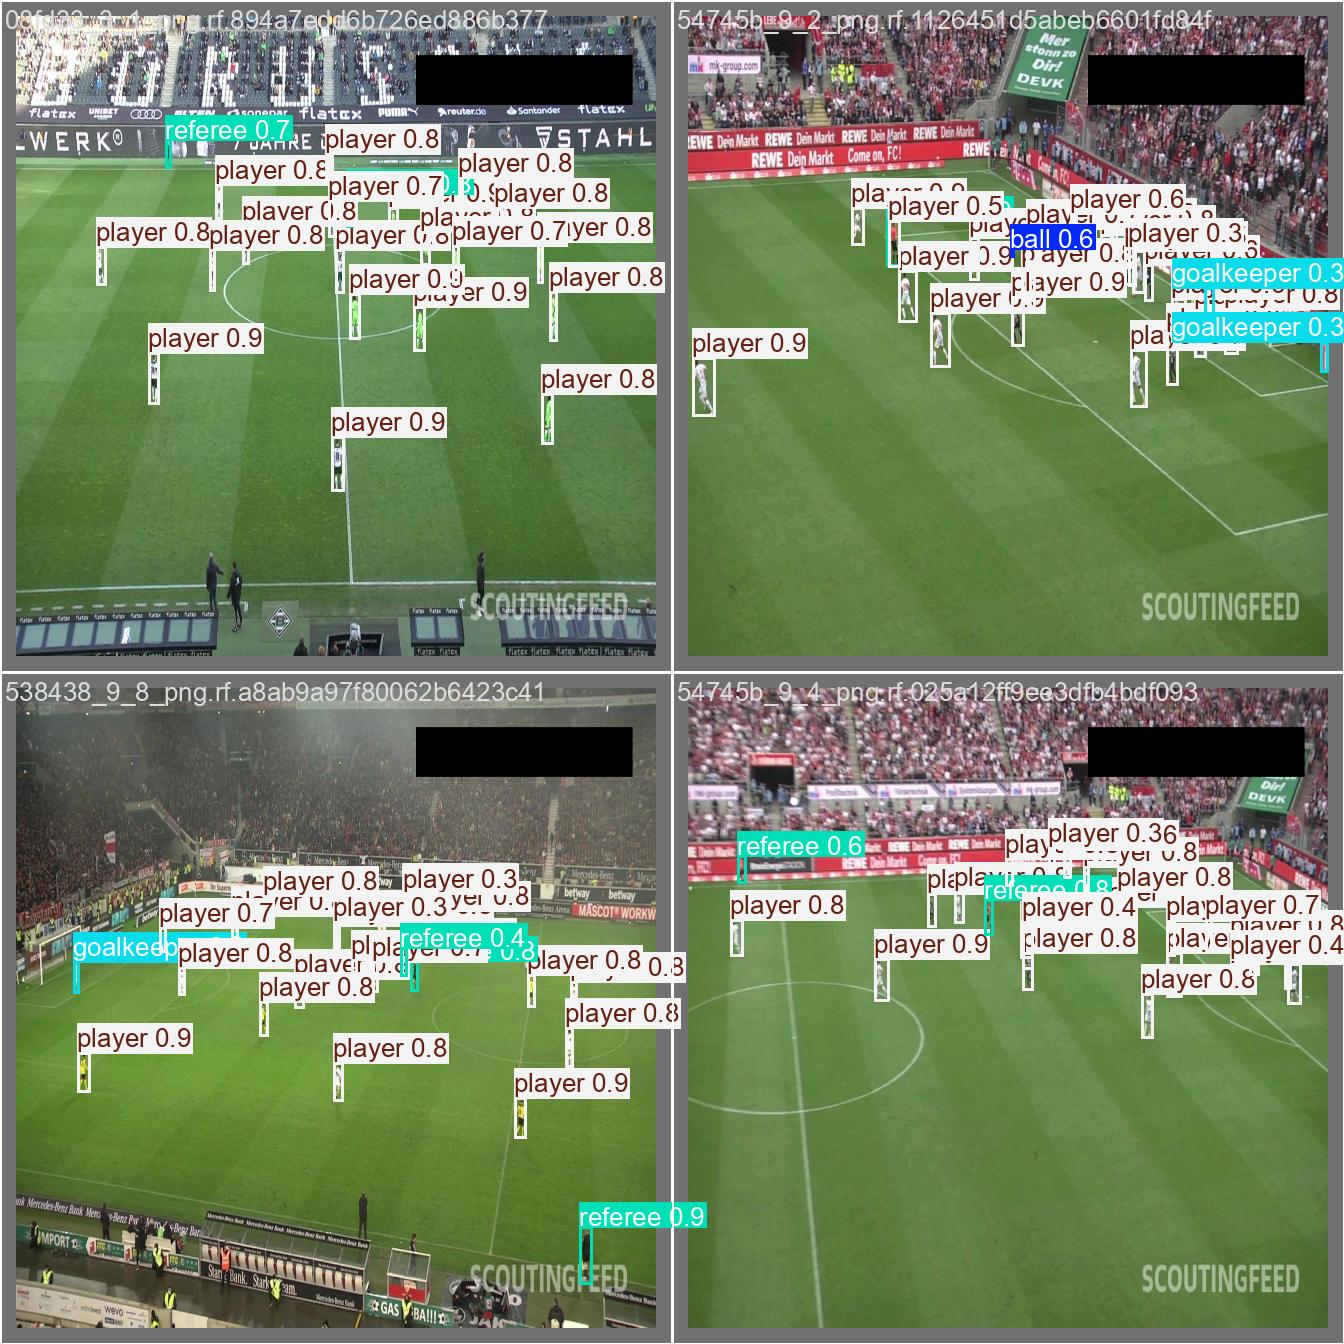

In [35]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train4/val_batch0_pred.jpg', width=600)

## Validate custom model

In [36]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train4/weights/best.pt data={dataset.location}/data.yaml imgsz=1280

/content
Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 268 layers, 68,127,420 parameters, 0 gradients, 257.4 GFLOPs
val: Scanning /content/datasets/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100% 49/49 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:13<00:00,  3.28s/it]
                   all         49       1174      0.754      0.571      0.667      0.425
                  ball         45         45      0.701      0.289      0.484      0.166
            goalkeeper         38         39      0.659      0.248      0.392      0.256
                player         49        973      0.885       0.97      0.972      0.746
               referee         49        117      0.772      0.778       0.82      0.532
Speed: 8.7ms preprocess, 233.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/d

## Deploy model on Roboflow

In [ ]:
project.version(dataset.version).deploy(model_type="yolov8", model_path=f"{HOME}/runs/detect/train/")

Dependency ultralytics==8.0.196 is required but found version=8.2.63, to fix: `pip install ultralytics==8.0.196`
Would you like to continue with the wrong version of ultralytics? y/n: y
View the status of your deployment at: https://app.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/10
Share your model with the world at: https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/model/10
